In [2]:
!pip install transformers
!pip install keras_nlp
!pip install datasets
!pip install huggingface-hub huggingface_hub
!pip install nltk
!pip install rouge-score rouge
!pip install evaluate
!apt install git-lfs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 33.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 23.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 68.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.7/527.7 kB 34.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 81.3 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 35.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 24.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 19

In [3]:
from huggingface_hub import notebook_login

notebook_login()

In [4]:
!git config --global user.email "oabass7@gmail.com"
!git config --global user.name "Jammal"

In [5]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from datasets import load_dataset, load_metric, load_from_disk
from transformers import AutoTokenizer, TFAutoModelForSeq2SeqLM, DataCollatorForSeq2Seq, AdamWeightDecay, create_optimizer 
from transformers.keras_callbacks import  KerasMetricCallback
import evaluate
import nltk
from nltk.corpus import stopwords
nltk.download('punkt')

# Only log error messages
import logging
tf.get_logger().setLevel(logging.ERROR)

os.environ["TOKENIZERS_PARALLELISM"] = "false"

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


## Loading the dataset

### About Dataset
[BIGPATENT](https://huggingface.co/datasets/big_patent), consisting of 1.3 million records of U.S. patent documents along with human written abstractive summaries. Each US patent application is filed under a Cooperative Patent Classification (CPC) code. There are nine such classification categories:

* a: Human Necessities
* b: Performing Operations; Transporting
* c: Chemistry; Metallurgy
* **d: Textiles; Paper**
* e: Fixed Constructions
* f: Mechanical Engineering; Lightning; Heating; Weapons; Blasting
* g: Physics
* h: Electricity
* y: General tagging of new or cross-sectional technology

I will be working with 1 out of the 9 classification categories due to low compute unit.

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
# df = load_dataset("big_patent", "d")

In [8]:
# saving the data
# df.to_csv('/content/drive/MyDrive/Data_Science/Bigpatent_Summarization/d.csv', index=False)
# df.save_to_disk('/content/drive/MyDrive/Data_Science/Bigpatent_Summarization/d_dataset')

In [9]:
df = load_from_disk('/content/drive/MyDrive/Data_Science/Bigpatent_Summarization/d_dataset')
print(df)

DatasetDict({
    train: Dataset({
        features: ['description', 'abstract'],
        num_rows: 10164
    })
    validation: Dataset({
        features: ['description', 'abstract'],
        num_rows: 565
    })
    test: Dataset({
        features: ['description', 'abstract'],
        num_rows: 565
    })
})


In [10]:
df['train'] = df['train'].shuffle(seed=42).select(range(1000))

In [11]:
print(df)

DatasetDict({
    train: Dataset({
        features: ['description', 'abstract'],
        num_rows: 1000
    })
    validation: Dataset({
        features: ['description', 'abstract'],
        num_rows: 565
    })
    test: Dataset({
        features: ['description', 'abstract'],
        num_rows: 565
    })
})


### Define Certain Variables

In [12]:
# Maximum length of the input to the model
MAX_INPUT_LENGTH = 1024  

# Minimum length of the output by the model
MIN_TARGET_LENGTH = 5  
# Maximum length of the output by the model
MAX_TARGET_LENGTH = 128 

# Batch-size for training our model
BATCH_SIZE = 8

## T5 Model

#### Data preprocessing

In [13]:
MODEL_CHECKPOINT = "t5-small"

tokenizer = AutoTokenizer.from_pretrained(MODEL_CHECKPOINT)

if MODEL_CHECKPOINT in ["t5-small", "t5-base", "t5-large", "t5-3b", "t5-11b"]:
    prefix = "summarize: "
else:
    prefix = ""

In [14]:
def preprocess_function(examples):
    inputs = [prefix + inp for inp in examples["description"]]
    model_inputs = tokenizer(inputs, max_length=MAX_INPUT_LENGTH, truncation=True)
    targets = examples["abstract"]

    # Setup the tokenizer for targets
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(targets, max_length=MAX_TARGET_LENGTH, truncation=True)

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [15]:
tokenized_df = df.map(preprocess_function, batched=True)

In [16]:
tokenized_df["train"]

Dataset({
    features: ['description', 'abstract', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 1000
})

### Fine-tuning the Model

In [17]:
model = TFAutoModelForSeq2SeqLM.from_pretrained(MODEL_CHECKPOINT)

All model checkpoint layers were used when initializing TFT5ForConditionalGeneration.

All the layers of TFT5ForConditionalGeneration were initialized from the model checkpoint at t5-small.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.


In [18]:
# pushing the model to tensorflow hub
model_name = MODEL_CHECKPOINT.split("/")[-1]
push_to_hub_model_id = f"{model_name}-finetuned-Big-Patent"

In [19]:
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model, return_tensors="tf")
generation_data_collator = DataCollatorForSeq2Seq(tokenizer, model=model, return_tensors="np", pad_to_multiple_of=128)

In [20]:
tf_train_set = model.prepare_tf_dataset(
    tokenized_df["train"],
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=data_collator,
)

tf_validation_set = model.prepare_tf_dataset(
    tokenized_df["validation"],
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=data_collator,
)

tf_generation_set = model.prepare_tf_dataset(
    tokenized_df["validation"],
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=generation_data_collator
)

You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


### Compiling the Model

In [21]:
optimizer = AdamWeightDecay(learning_rate=2e-5, weight_decay_rate=0.01) 
model.compile(optimizer=optimizer)

No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! To disable this behaviour please pass a loss argument, or explicitly pass `loss=None` if you do not want your model to compute a loss.


### Evaluate the Model

In [22]:
metric = load_metric("rouge")

def metric_fn(eval_predictions):
    predictions, labels = eval_predictions
    decoded_predictions = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    for label in labels:
        label[label < 0] = tokenizer.pad_token_id  # Replace masked label tokens
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    # Rouge expects a newline after each sentence
    decoded_predictions = [
        "\n".join(nltk.sent_tokenize(pred.strip())) for pred in decoded_predictions
    ]
    decoded_labels = [
        "\n".join(nltk.sent_tokenize(label.strip())) for label in decoded_labels
    ]
    result = metric.compute(
        predictions=decoded_predictions, references=decoded_labels, use_stemmer=True
    )
    # Extract a few results
    result = {key: value.mid.fmeasure * 100 for key, value in result.items()}
    # Add mean generated length
    prediction_lens = [
        np.count_nonzero(pred != tokenizer.pad_token_id) for pred in predictions
    ]
    result["gen_len"] = np.mean(prediction_lens)

    return result

In [23]:
# from transformers.keras_callbacks import PushToHubCallback, KerasMetricCallback
# from tensorflow.keras.callbacks import TensorBoard

# tensorboard_callback = TensorBoard(log_dir="./summarization_model_save/logs")

# push_to_hub_callback = PushToHubCallback(
#     output_dir="./summarization_model_save",
#     tokenizer=tokenizer,
#     hub_model_id=push_to_hub_model_id,
# )

### Train the Model

In [24]:
metric_callback = KerasMetricCallback(
    metric_fn, eval_dataset=tf_generation_set, predict_with_generate=True, use_xla_generation=True
)

# callbacks = [metric_callback, tensorboard_callback, push_to_hub_callback]
callbacks = [metric_callback]

history = model.fit(x=tf_train_set, validation_data=tf_validation_set, epochs=20, callbacks=callbacks)

Epoch 1/20
125/125 [==============================] - 231s 2s/step - loss: 2.9639 - val_loss: 2.5404 - rouge1: 18.3163 - rouge2: 7.8090 - rougeL: 14.7378 - rougeLsum: 15.9580 - gen_len: 19.0000
Epoch 2/20
125/125 [==============================] - 143s 1s/step - loss: 2.6146 - val_loss: 2.4236 - rouge1: 19.3100 - rouge2: 8.2242 - rougeL: 15.3463 - rougeLsum: 16.8402 - gen_len: 19.0000
Epoch 3/20
125/125 [==============================] - 141s 1s/step - loss: 2.5263 - val_loss: 2.3841 - rouge1: 20.3325 - rouge2: 9.2902 - rougeL: 16.4588 - rougeLsum: 17.8995 - gen_len: 19.0000
Epoch 4/20
125/125 [==============================] - 138s 1s/step - loss: 2.4724 - val_loss: 2.3536 - rouge1: 21.3813 - rouge2: 10.0949 - rougeL: 17.4234 - rougeLsum: 18.7678 - gen_len: 19.0000
Epoch 5/20
125/125 [==============================] - 137s 1s/step - loss: 2.4287 - val_loss: 2.3292 - rouge1: 21.7078 - rouge2: 10.4524 - rougeL: 17.9202 - rougeLsum: 19.1961 - gen_len: 19.0000
Epoch 6/20
125/125 [========

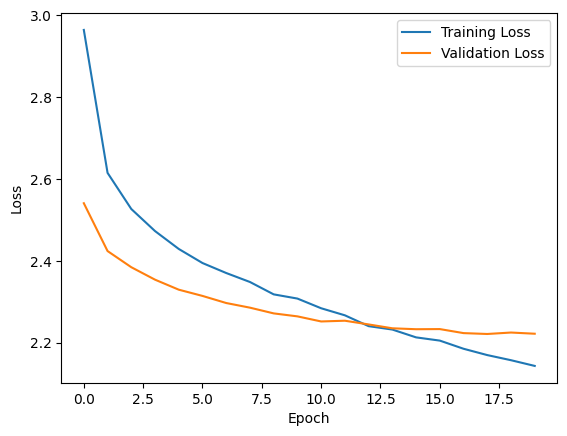

In [25]:
# Plot the metrics
train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [26]:
from transformers import TFAutoModelForSeq2SeqLM

model = TFAutoModelForSeq2SeqLM.from_pretrained("Jammal7/t5-small-finetuned-Big-Patent")

All model checkpoint layers were used when initializing TFT5ForConditionalGeneration.

All the layers of TFT5ForConditionalGeneration were initialized from the model checkpoint at Jammal7/t5-small-finetuned-Big-Patent.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.


In [27]:
# # Save the model in SavedModel format
# model.save_pretrained("/content/drive/MyDrive/Data_Science/Bigpatent_Summarization/t5_model")

### Test the model

In [28]:
# Assign the model path to model_name
model_name = "Jammal7/t5-small-finetuned-Big-Patent"

# Load the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = TFAutoModelForSeq2SeqLM.from_pretrained(model_name)

All model checkpoint layers were used when initializing TFT5ForConditionalGeneration.

All the layers of TFT5ForConditionalGeneration were initialized from the model checkpoint at Jammal7/t5-small-finetuned-Big-Patent.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.


In [29]:
# df['test'][0]['description']

In [30]:
document = df['test'][0]['description']
if 't5' in model_name: 
    document = "summarize: " + document

In [31]:
tokenized = tokenizer([document], return_tensors='np')
out = model.generate(**tokenized, max_length=128)
with tokenizer.as_target_tokenizer():
    print(tokenizer.decode(out[0]))

Token indices sequence length is longer than the specified maximum sequence length for this model (8952 > 512). Running this sequence through the model will result in indexing errors


ResourceExhaustedError: ignored

In [ ]:
tokenized = tokenizer([document], return_tensors='tf')
out = model.generate(input_ids=tokenized.input_ids, attention_mask=tokenized.attention_mask, max_length=128)
summary = tokenizer.decode(out[0])

print("Summary:")
print(summary)

In [ ]:
df['test'][0]['abstract']

## MT5 Model, BART, PEGASUS, GP3